All of the energy flux calculations in one plot

In [1]:
import matplotlib.pylab as plt
import numpy as np
import scipy.io as sio
import netCDF4 as nc

from salishsea_tools import viz_tools
from nowcast.figures import research_VENUS
from nowcast import analyze

import energy_flux as ef
import datetime

import os

%matplotlib inline

In [2]:
grid=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
NEMO_lons = grid.variables['nav_lon'][:]
NEMO_lats = grid.variables['nav_lat'][:]
bathy=grid.variables['Bathymetry'][:]

mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][0,:,:,:]
e3t = mesh.variables['e3t'][0,:,:,:]

In [3]:
def load_area(areaname, date1, date2, path):
    
    d1str = date1.strftime('%Y%m%d')
    d2str = date2.strftime('%Y%m%d')
    
    data = sio.loadmat(os.path.join(path, '{}_region_{}_{}_ssh'.format(areaname, d1str, d2str)))
    sshstruc = data['sshstruc']

    data = sio.loadmat(os.path.join(path, '{}_region_baroclinic_{}_{}_masked'.format(areaname, d1str, d2str)))
    bcstruc = data['datastruc']

    data = sio.loadmat(os.path.join(path, '{}_region_{}_{}_pbc_t'.format(areaname, d1str, d2str)))
    pbc_t_struc = data['pbc_t_struc']

    data = sio.loadmat(os.path.join(path, '{}_region_depav_{}_{}_masked'.format(areaname, d1str, d2str)))
    btstruc = data['datastruc']
    
    return sshstruc, bcstruc, pbc_t_struc, btstruc

In [4]:
areas = ['CODAR/CODAR', 'BP', 'JuandeFuca', 'VictoriaSill', ]
path = '/ocean/nsoontie/MEOPAR/TidalEllipseData/'
d1 = datetime.datetime(2014,11,26)
d2 = datetime.datetime(2015,4,26)

In [5]:
sshs = {}
bcs = {}
pbcs = {}
bts = {}

for area in areas:
    sshs[area], bcs[area], pbcs[area], bts[area] = load_area(area, d1,d2,path)

# Plot depth integrate barotropic energy flux

In [6]:
column_depth = ef.water_depth(tmask,e3t)

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3117: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  dout = self.data[indx]
/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/numpy/ma/core.py:3172: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  dout._mask = _mask[indx]


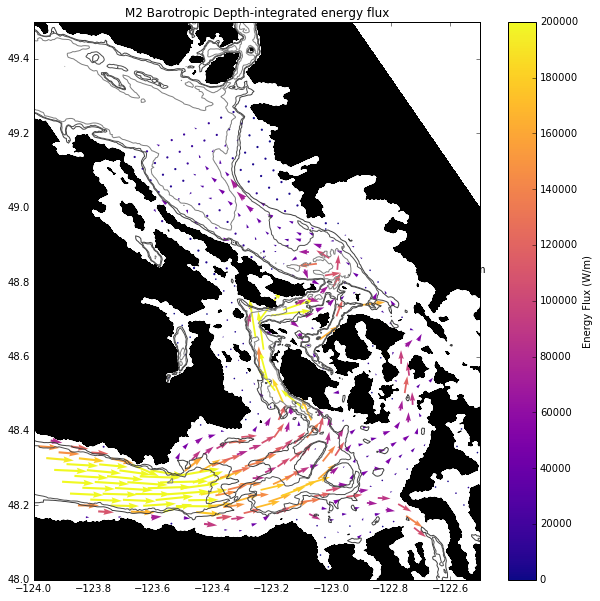

In [9]:
st=8
const='M2'
scale=5*1e5
scale_unit='inches'
fig, ax = plt.subplots(1,1,figsize=(10,10))
for area in areas:
    lons = sshs[area]['lons'][0,0]
    lats = sshs[area]['lats'][0,0]

    jstart,istart = ef.find_starting_index(NEMO_lons,NEMO_lats,lons[0,0],lats[0,0])
    
    Fxbt,Fybt = ef.barotropic_flux(sshs[area], bts[area], const)

    jend = jstart + Fxbt.shape[-1]
    iend = istart + Fxbt.shape[0]

    Fxbt_depint = Fxbt*column_depth[jstart:jend, istart:iend].T
    Fybt_depint = Fybt*column_depth[jstart:jend, istart:iend].T
    
    mag = np.sqrt(Fxbt_depint**2+Fybt_depint**2)
    
    q=ax.quiver(lons[::st,::st],lats[::st,::st],
                Fxbt_depint[::st,::st],Fybt_depint[::st,::st,],
                mag[::st,::st],cmap='plasma',clim=[0,2*1e5],scale=scale, scale_units=scale_unit)

ax.set_xlim([-124,-122.5])
ax.set_ylim([48,49.5])    
ax.quiverkey(q,-122.6,48.8,2*1e5,'200, 000 W/m',color='k', coordinates='data')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Energy Flux (W/m)')
C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
viz_tools.plot_land_mask(ax, grid, coords='map')
ax.set_title('{} Barotropic Depth-integrated energy flux'.format(const))